<a href="https://colab.research.google.com/github/Colonna17/Collision_Avoidance-Sapienza_Vision_and_Perception/blob/main/CCD_Classification_cnn%26lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import os, cv2
import numpy as np
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!nvidia-smi

Fri Jan 13 21:25:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# # togliere se il contenuto non viene mai usato
# !git clone --recurse-submodules https://github.com/Colonna17/Collision_Avoidance-Sapienza_Vision_and_Perception.git

# %pip install -qr external/yolov5/requirements.txt 
# %pip install -qr requirements.txt #install dependencies

# Utils

In [ ]:
# Transform a numpy array of an image from bgr to rgb format
def numpy_brg_to_rgb(np_array):
    return np.fliplr(np_array.reshape(-1,3)).reshape(np_array.shape).copy()

In [ ]:
def custom_from_numpy(np_array):
    return torch.from_numpy(np_array).to(device=device, dtype=torch.float32)

# Create the dataset 

In [ ]:
# %cd /content/drive/MyDrive/Vision and Perception Project/Car Crash Dataset
data_dir = '/content/drive/MyDrive/Vision and Perception Project/Car Crash Dataset/videos'

# Cosa cambia?
# test_video_dir = data_dir + "/Crash-1500/"
test_video_dir = data_dir + '/Test-Crash/'
# test_annotation_file = data_dir + "/Crash-1500.txt"
test_annotation_file = data_dir + '/test_annontations.txt'

In [ ]:
!ls /content/drive/MyDrive/Vision\ and\ Perception\ Project/Car\ Crash\ Dataset/videos # data_dir

Crash-1500	Crash-1500.zip	Normal.zip	       Test-Crash
Crash-1500.txt	Normal-3000	test_annontations.txt


In [ ]:
# [REMINDER] X: A tensor of size (B =batch_size, T =num_channels, C =seq_len, H = height, W = width)

class CCDVideos(Dataset):
    def __init__(self, videos_directory, annotations_path):
        super().__init__()
        self.videos_paths = [ videos_directory + video_name for video_name in os.listdir(videos_directory) ]
        self.videos_paths.sort()
        self.annotations = self.read_annotations_file(annotations_path)

    def __getitem__(self, idx):
        video_frames = self.get_video_frames(self.videos_paths[idx])
        video_annotations = self.annotations[idx]
        return {'frames': video_frames, 'annotations': video_annotations}

    def __len__(self):
        return len(self.videos_paths)

    def read_annotations_file(self, annotations_path):
        assert os.path.exists(annotations_path), "Annotation file does not exist!" + annotations_path
        result = []
        with open(annotations_path, 'r') as f:
            for line in f.readlines():
                items = {}
                items['vid'] = line.strip().split(',[')[0]
                labels = line.strip().split(',[')[1].split('],')[0]
                items['labels'] = [int(val) for val in labels.split(',')]
                others = line.strip().split(',[')[1].split('],')[1].split(',')
                items['startframe'], items['vid_ytb'], items['lighting'], items['weather'], items['ego_involve'] = others
                result.append(items)
        f.close()
        return result

    def get_video_frames(self, video_file, topN=50):
        # get the video data
        cap = cv2.VideoCapture(video_file)
        ret, frame = cap.read() # Cos'è ret?
        
        video_data = []
        while (ret):
            video_data.append(frame)
            ret, frame = cap.read()
        
        # Necessario?
        assert len(video_data) >= topN 
        video_data = video_data[:topN]
        
        return video_data

In [ ]:
ccd_dataset = CCDVideos(test_video_dir, test_annotation_file)
# loader = DataLoader(ccd_dataset, batch_size=1) #, num_workers=0)

(720, 1280, 3) <class 'numpy.ndarray'>
Annotation:  1


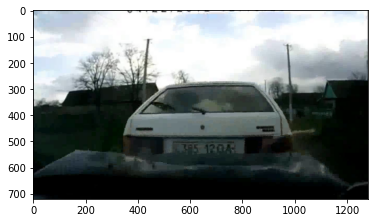

In [ ]:
test = ccd_dataset[3]
frame_nr = 45
img_test = test['frames'][frame_nr]

img_test = numpy_brg_to_rgb(img_test) # Needed?

print(img_test.shape, type(img_test))
print('Annotation: ', test['annotations']['labels'][frame_nr])
plt.imshow(img_test)

# Model

In [ ]:
class HParams():
    # Model parameters
    img_size = (720, 1280, 3)
    lstm_hidden_dim = 32
    collision_threshold = 0.5
    
    # Training parameters
    lr = 1e-4
    num_epochs = 5

params = HParams()
params.device = device

In [ ]:
class Classificator(nn.Module):
    def __init__(self, parameters):
        super().__init__()
        self.device = parameters.device
        self.loss_fn = nn.BCELoss()

        # ToDo: Add CNN initialization here

        lstm_input_size = parameters.img_size[0] * parameters.img_size[1] * parameters.img_size[2] # Must be changed if we introduce a CNN
        self.lstm = torch.nn.LSTM(lstm_input_size, params.lstm_hidden_dim)
        self.relu = torch.nn.ReLU()

        self.linear_classifier = torch.nn.Linear(params.lstm_hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    

    def forward(self, input, h=None):
        # ToDo: decide the format of the input
        # if(some_condition): input = torch.from_numpy(input).to(device=device, dtype=torch.float32)

        # ToDo: use CNN here to produce the input for the lstm
        flat_input = torch.flatten(input).unsqueeze(0)

        output, (h, c) = self.lstm(flat_input, h)
        output = self.relu(output)

        output = self.linear_classifier(output)
        output = self.sigmoid(output)

        return output, (h, c)
    
    def loss(self, pred, y):
        return self.loss_fn(pred, y)


model = Classificator(params).to(device)

In [ ]:
# # Single trame test
# model.eval()
# test_tensor = custom_from_numpy(img_test)
# test_output, h = model(test_tensor)
# test_output

In [ ]:
# Entire video test
model.eval()
predictions = []
h = None
for frame in test['frames']:
    frame = custom_from_numpy(frame)
    pred, h = model(frame, h)

    predictions.append((pred.item(), pred.item() > params.collision_threshold))

predictions

[(0.478543758392334, False),
 (0.4856824278831482, False),
 (0.4867771863937378, False),
 (0.4869280755519867, False),
 (0.48694854974746704, False),
 (0.4869512617588043, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.5230967998504639, True),
 (0.5230967998504639, True),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.48695170879364014, False),
 (0.5155078172683716, True),
 (0.5155078172683716, True),
 (0.5514940619468689, True),
 (0.5514940619468689, True),
 (0.5155078172683716, True),
 (0.5155078172683716, True),
 (0.5230967998504639, True),
 (0.5230967998504639, True),
 (0.5230967998504639, True),
 (0.48695170879364014, False),
 (0.5230967998504639, True),
 (0.523

# TRAINING


In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=params.lr)

In [ ]:
def train(model, optimizer, train_dataset):
    torch.cuda.empty_cache()
    train_history = []
    valid_history = []

    for epoch in range(params.num_epochs):
        print('Epoch {:03d}:'.format(epoch + 1))

        epoch_loss = 0.0
        model.train() 

        for step, video in enumerate(train_dataset):
            print('\tVideo nr: ', step)
            frames = video['frames']
            labels = torch.FloatTensor(video['annotations']['labels']).to(params.device)
            
            optimizer.zero_grad()

            predictions = torch.FloatTensor().to(params.device)
            h = None
            for frame in frames:
                frame = custom_from_numpy(frame)
                pred, h = model(frame, h)
                
                predictions = torch.cat((predictions, pred))
            
            predictions = predictions.squeeze()
            # predictions = predictions.view(-1, predictions.shape[-1])
            # labels = labels.view(-1)

            sample_loss = model.loss(predictions, labels)
            sample_loss.backward()
            optimizer.step()

            epoch_loss += sample_loss.tolist()

        avg_epoch_loss = epoch_loss / len(train_dataset)
        train_history.append(avg_epoch_loss)
        print('\tTrain loss = {:0.4f}'.format(avg_epoch_loss))

        # avg_valid_loss = evaluate(model, valid_dataset)
        # valid_history.append(avg_valid_loss)
        # print('\tValid loss = {:0.4f}'.format(avg_valid_loss))
        # if early_stopping:
        #     stop = epoch > 0 and valid_history[-1] > valid_history[-2]
        #     if stop:
        #         if patience <= 0:
        #             if(verbose): print('\tEarly stop.')
        #             break
        #         else:
        #             if(verbose): print('\tPatience.')
        #             patience -= 1

    return {'train_history': train_history, 'valid_history': valid_history}

In [ ]:
# def evaluate(model, validation_dataset):
#     return

In [ ]:
logs = train(model, optim, ccd_dataset)

Epoch 001:
	Video nr:  0
	Video nr:  1
	Video nr:  2
	Video nr:  3
	Video nr:  4
	Video nr:  5
	Video nr:  6
	Video nr:  7
	Video nr:  8
	Video nr:  9
	Train loss = 0.6997
Epoch 002:
	Video nr:  0
	Video nr:  1
	Video nr:  2
	Video nr:  3
	Video nr:  4
	Video nr:  5
	Video nr:  6
	Video nr:  7
	Video nr:  8
	Video nr:  9
	Train loss = 0.6940
Epoch 003:
	Video nr:  0
	Video nr:  1
	Video nr:  2
	Video nr:  3
	Video nr:  4
	Video nr:  5
	Video nr:  6
	Video nr:  7
	Video nr:  8
	Video nr:  9
	Train loss = 0.6934
Epoch 004:
	Video nr:  0
	Video nr:  1
	Video nr:  2
	Video nr:  3
	Video nr:  4
	Video nr:  5
	Video nr:  6
	Video nr:  7
	Video nr:  8
	Video nr:  9
	Train loss = 0.6927
Epoch 005:
	Video nr:  0
	Video nr:  1
	Video nr:  2
	Video nr:  3
	Video nr:  4
	Video nr:  5
	Video nr:  6
	Video nr:  7
	Video nr:  8
	Video nr:  9
	Train loss = 0.6920


In [ ]:
model.eval()
optim.zero_grad()
torch.cuda.empty_cache()

In [ ]:
def plot_training_logs(logs, title, out_img_name):
    plt.figure(figsize=(15,10))

    plt.plot(list(range(len(logs['train_history']))), logs['train_history'], label='Train loss')
    # plt.plot(list(range(len(logs['valid_history']))), logs['valid_history'], label='Test loss')
    
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="upper right")
    plt.savefig(out_img_name)
    plt.show()

In [ ]:
logs

{'train_history': [0.6997361361980439,
  0.6940302550792694,
  0.6933571875095368,
  0.6926935613155365,
  0.6920358598232269],
 'valid_history': []}

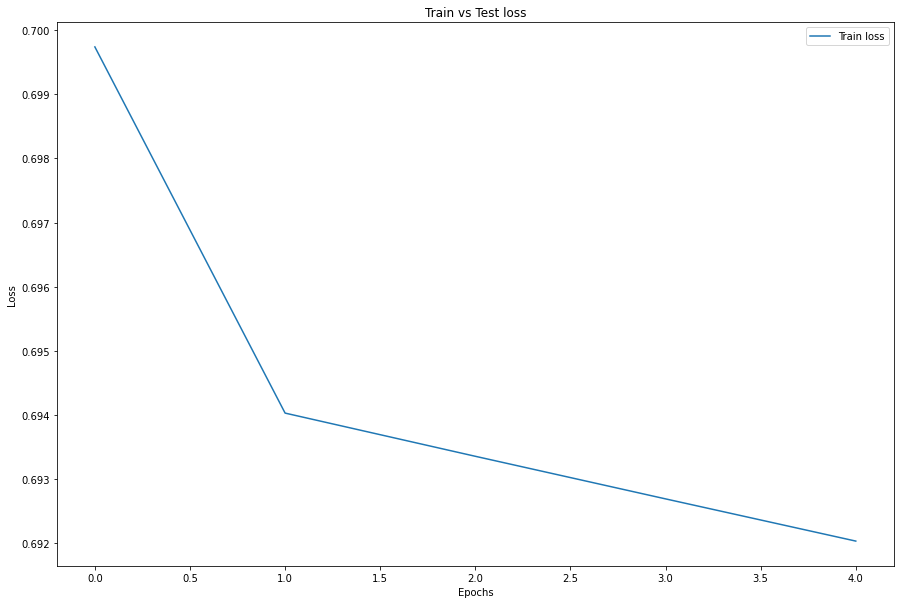

In [ ]:
plot_training_logs(logs, 'Train vs Test loss', 'loss_plot.png')

# Original Model

In [ ]:
# Original ConvLSTM cell as proposed by Shi et al.
# Adapted from https://github.com/ndrplz/ConvLSTM_pytorch

class ConvLSTMCell(torch.nn.Module):

    def __init__(self, in_channels, out_channels,  kernel_size, padding, activation, frame_size):
        """
        Initialize ConvLSTM cell.
        Parameters
        ----------
        in_channels: int
            Number of channels of input tensor.
        out_channels: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        """

        # super(ConvLSTMCell, self).__init__()  # Perchè?
        super().__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        self.conv = nn.Conv2d(in_channels = in_channels + out_channels, 
                              out_channels = 4 * out_channels, 
                              kernel_size = kernel_size, 
                              padding = padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):
        """
        The following are all 3D tensors: first dimension is n° of channels/filters
        while second and third are Height and Width of a frame.
        i: input gate
        f: forget gate
        o: output gate
        C: cell state
        H: hidden state
        X: inputs
        W: weights matrices. They are a learnable set of kernels.
        """

        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [ ]:
# Original ConvLSTM cell as proposed by Shi et al.
# Adapted from https://github.com/ndrplz/ConvLSTM_pytorch

class ConvLSTM(nn.Module): 
    """
    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.
    Input:
       X: A tensor of size (B =batch_size, T =num_channels, C =seq_len, H = height, W = width)
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, in_channels, out_channels, kernel_size, padding, activation, frame_size):
        # super(ConvLSTM, self).__init__()
        super().__init__()        

        self.out_channels = out_channels

        # We will unroll this over time steps. Remember that convLSTMcell returns
        # H hidden state and C cell
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, kernel_size, padding, activation, frame_size)

    
    # X is a frame sequence of size (B, T, C, H, W) with (B = batch_size, T = num_channels, C = seq_len, H = height, W = width)
    def forward(self, X):
        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size() # what is the ignored parameter

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [ ]:

class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, activation, frame_size, num_layers):
        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        # self.sequential.add_module(
        #     "batchnorm", nn.BatchNorm3d(num_features=num_kernels)
        # ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        outpu = nn.Sigmoid()(output)
        
        return output

# Roba a caso

In [ ]:
# !pip install wandb
# import wandb
# wandb.init()

In [ ]:
# import nvidia_smi

# nvidia_smi.nvmlInit()

# deviceCount = nvidia_smi.nvmlDeviceGetCount()
# for i in range(deviceCount):
#     handle = nvidia_smi.nvmlDeviceGetHandleByIndex(i)
#     info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)
#     print("Device {}: {}, Memory : ({:.2f}% free): {}(total), {} (free), {} (used)".format(i, nvidia_smi.nvmlDeviceGetName(handle), 100*info.free/info.total, info.total, info.free, info.used))

# nvidia_smi.nvmlShutdown()

Device 0: b'Tesla T4', Memory : (3.20% free): 15843721216(total), 507248640 (free), 15336472576 (used)


In [ ]:
# # prints currently alive Tensors and Variables
# import torch
# import gc
# for obj in gc.get_objects():
#     try:
#         if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
#             print(type(obj), obj.size(), obj.element_size() * obj.nelement())
#     except:
#         pass
#     del obj

In [ ]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))